# FarmVibes.AI optimal locations identification
This notebook demonstrates identification of optimal locations by learning clusters in sentinel indices (EVI or NDMI or NDWI or combination of indices etc.,). The optimal locations identified can be used to collect soil properties by installing sensors  or performing other manual operations at the locations identified. The selection of sentinel indices as input to perform clustering operation depends on requirement, some examples on selection of indices provided in below sections. The soil properties collected at these locations can be used to generate the nutrients heatmap for the farm land etc. The example of generating nutrients heatmap for "C", "N", "P" and "pH" demonstrated using the soil properties collected through sensor installed at locations identified in notebook [heatmaps/nutrients_using_neighbors.ipynb](../heatmaps/nutrients_using_neighbors.ipynb).

This workflow ingests user data into the cluster. The reference to the data should be accessible via the internet and, for this demo, we assume it is saved in a remote location such as Azure blob storage.

### Micromamba environment setup
We provide a micromamba environment with the package requirements to run this notebook. If you do not have micromamba installed, please follow the instructions from [micromamba installation guide](https://mamba.readthedocs.io/en/latest/installation/micromamba-installation.html).

The micromamba environment can be created and activated using the commands below:
```bash
$ micromamba env create -f ./optimal_sample_collection.yaml
$ micromamba activate optimal_sample_collection
```

### Useful libraries

Below are the main libraries used for this example and other useful links:
- [NumPy](https://github.com/numpy/numpy) is a python package that provides powerful N-dimensional array object, broadcasting functions and useful linear algebra, Fourier transform, and random number capabilities.
- [pandas](https://github.com/scikit-learn/scikit-learn) is a Python package that provides fast, flexible, and expressive data structures designed to make working with "relational" or "labeled" data both easy and intuitive.
- [rasterio](https://github.com/rasterio/rasterio) is a library for reading and writing geospatial raster data. It is used on torchgeo and rioxarray. It is a good option when reading/writing GeoTIFFs.
- [Scikit-Learn](https://github.com/scikit-learn/scikit-learn) is a Python package for machine learning built on top of SciPy. It Simple and efficient tools for predictive data analysis.
- [Shapely](https://github.com/shapely/shapely) is a library for manipulating geometric shapes.

### Imports & API Client

In [1]:
from datetime import datetime
from vibe_core.client import get_default_vibe_client
import geopandas as gpd
from matplotlib import pyplot as plt
from notebook_lib import utils

## Workflow Inputs
The main workflow inputs are as follows:
- [farm_boundary](https://geojson.org/): Boundary of the field in geojson format. It is used to clip the satellite imagery to an area of interest and run the workflow. A sample field boundary is provided in the file `./sensor_farm_boundary.geojson`.

- imagery: Satellite imagery with multispectral bands to create raster indices. In this demo we are using Sentinel-2 imagery, which can be ingested by running a FarmVibes.AI workflow or a user provided url.

*Note - The provided sample data (sensor_farm_boundary.geojson, sensor_samples.geojson) is intended to help the user understand how to run the workflow and contains mock data.*

In [2]:
FARM_BOUNDARY = "./sensor_farm_boundary.geojson"

## Satellite imagery
Below we outline two methods for getting a raster that contains the satellite imagery used to generate the heatmap. Run the appropriate section below to ingest the data according to your preference.

### 1. Use the FarmVibes.AI workfow
FarmVibes.AI has several workflows that will ingest and preprocess data from many sources. Below we demonstrate how to obtain Sentinel-2 imagery for a desired location (our field boundary) and time range (some time around when the field samples were collected).

In [3]:
START_DATE=datetime(day=30, month=6, year=2022)
END_DATE=datetime(day=2, month=7, year=2022)

In [4]:
# sr_id: EPSG code for the coordinate system (CRS) used in the GeoJSON file
# containing the field boundary
# EPSG:4326 is the WGS-84 CRS (lat-lon) usually used in GeoJSON files
# Change this if your samples are provided in a different (projected) CRS
imagery = utils.download_sentinel_raster(
    farm_boundary=FARM_BOUNDARY,
    time_range=(START_DATE, END_DATE),
    sr_id=4326
)

### 2. Ingest user-provided TIFF
Run this if you prefer ingesting your own raster into the cluster that already exist in azure storage account. The raster ingesting should have required bands to compute index in next section. 

For example, if you're ingesting the Sentinel Raster then bands should be mapped as below. It's the format supported by [Spyndex library](https://github.com/awesome-spectral-indices/awesome-spectral-indices#expressions)

{'B01': 0, 'B02': 1, 'B03': 2, 'B04': 3, 'B05': 4, 'B06': 5, 'B07': 6, 'B08': 7, 'B8A': 8, 'B09': 9, 'B11': 10, 'B12': 11}

If you are ingesting custom multi spectral raster image that has three bands representing red, blue and nir then bands should be mapped as below.

{"R": 0, "B": 1, "N": 2}

Note: To map the bands for Sentinel, Landsat etc., look at respective columns in [Spyndex library documentation](https://github.com/awesome-spectral-indices/awesome-spectral-indices#expressions), if column not found then map the bands based on column "Standard"


In [ ]:
# Url the cluster will use to access the file, e.g., a signed blob URL
IMAGERY_URL = "<SAS URL>"

In [ ]:
# Ingest the data into the cluster. A `Raster` is returned
imagery = utils.get_raster_from_external(imagery_url=IMAGERY_URL, farm_boundary=FARM_BOUNDARY)
# Set the bands so that we know which band is what when computing indices
# These are the band names for an L2A Sentinel-2 raster
imagery.bands = {'B01': 0, 'B02': 1, 'B03': 2, 'B04': 3, 'B05': 4, 'B06': 5, 'B07': 6, 'B08': 7, 'B8A': 8, 'B09': 9, 'B11': 10, 'B12': 11}

### Identify optimal locations

In [7]:
client = get_default_vibe_client()
client.document_workflow("farm_ai/sensor/optimal_locations")

Workflow: farm_ai/sensor/optimal_locations

Description:

Identify optimal locations by performing clustering operation using Gaussian Mixture model on   
    computed raster indices. The clustering operation separate computed raster indices values into n
    groups of equal variance, each group assigned a location and that location is considered as a   
    optimal locations. The sample locations generated provide information of latitude and longitude.
    The optimal location can be utilized to install sensors and collect                             
    soil information. The index parameter used as input to run the computed index workflow          
    internally using the input raster submitted. The selection of index parameter varies            
    based on requirement. The workflow supports all the indices supported by spyndex library        
    (https://github.com/awesome-spectral-indices/awesome-spectral-indices#vegetation).              
    Below provided various indices that are used to identify optimal locations and generated a      
    nutrients heatmap.                                                                              
    Enhanced Vegetation Index (EVI) - EVI is designed to minimize the influence of soil brightness  
    and atmospheric conditions on vegetation assessment. It is calculated                           
    using the red, blue, and near-infrared (NIR) bands. EVI is particularly useful for monitoring   
    vegetation in regions with high canopy cover and in areas where atmospheric                     
    interference is significant. This indices also used in notebook                                 
    (notebooks/heatmaps/nutrients_using_neighbors.ipynb) that derive nutrient information for       
    Carbon, Nitrogen,                                                                               
    and Phosphorus.                                                                                 
    Photochemical Reflectance Index (PRI) - It is a vegetation index used to assess the light-use   
    efficiency of plants in terms of photosynthesis and their response to                           
    changes in light conditions, particularly variations in the blue and red parts of the           
    electromagnetic spectrum. This index also used in notebook                                      
    (notebooks/heatmaps/nutrients_using_neighbors.ipynb) that derive nutrient information for pH.   
    The number of sample locations generated depend on input parameters submitted. Tune n_clusters  
    and sieve_size parameters to generate more or less location data points.                        
    For a 100 acre farm,                                                                            
    - 20 sample locations are generated using n_clusters=5 and sieve_size=10.                       
    - 30 sample locations are generated using n_clusters=5 and sieve_size=20.                       
    - 80 sample locations are generated using n_clusters=5 and sieve_size=5.                        
    - 130 sample locations are generated using n_clusters=8 and sieve_size=5.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): DataVibe with time range information.

- input_raster (vibe_core.data.rasters.Raster): List of computed raster indices generated using 
    the sentinel 2 satellite imagery.

Sinks:

- result (vibe_core.data.core_types.DataVibe): Zip file containing sample locations in a shape  
    file (.shp) format.

Parameters:

- n_clusters (default: 1): number of clusters used to generate sample locations.

- sieve_size (default: 1): Group the nearest neighbor pixel values.

- index (default: ndvi): Index used to generate sample locations.

Tasks:

- compute_index: Computes an index from the bands of an input raster.

- find_samples: Find minimum soil sample locations by grouping indices values that are derived  
    from satellite or spaceEye imagery bands.

### Identifying n locations
Identifying n locations is important, it reduce the cost of the maintenance on choosing the optimal location. Creating the n locations varies based on number of clusters (n_clusters) to be identified in the input data and grouping the nearest neighbors (sieve_size).

Based on research conducted, identified below parameter combination provide n locations for different indices. These n locations identified for a 100 acre farm. Combinations may also vary based on soil properties, hence try altering parameter values based on your needs.

<table>
<tr><td>Index</td><td>Parameters</td><td>~ n samples</td></tr>
<tr><td>evi</td><td>n_clusters=5, sieve_size=25</td><td>20</td></tr>
<tr><td>evi</td><td>n_clusters=5, sieve_size=20</td><td>30</td></tr>
<tr><td>evi</td><td>n_clusters=5, sieve_size=5</td><td>80</td></tr>
<tr><td>evi</td><td>n_clusters=8, sieve_size=5</td><td>130</td></tr>
</table>


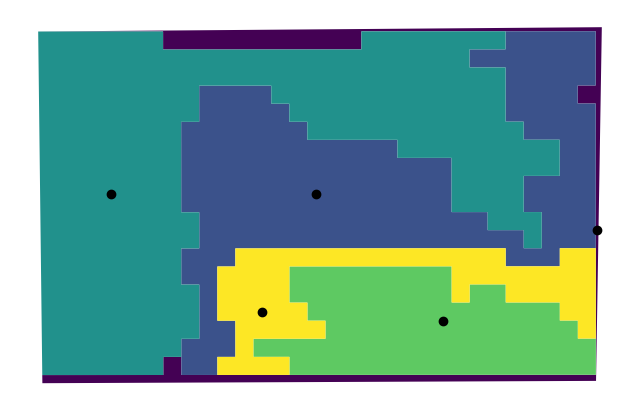

In [6]:
parameters = {"n_clusters": 5, "sieve_size": 20, "index":"evi"}
cluster_boundaries, samples_locations = utils.get_sample_locations(
                                                indices_raster=imagery,
                                                farm_boundary=FARM_BOUNDARY,
                                                sr_id=4326,
                                                time_range=(START_DATE, END_DATE),
                                                parameters=parameters)

### Review optimal locations
Before going to next step, check the number of optimal locations received solve the purpose of requirement, if not re-run the notebook by changing the input parameters.